In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import math
import random

STOP = -999999

Functions to initialize the WFC

In [2]:
def init(sample_name, N, output_size, rotate=False, reflect=False):
    patterns = get_patterns_from_sample(sample_name, N, rotate, reflect)
    weights = get_weights_from_patterns(patterns)
    unique_patterns = get_unique_patterns(patterns)
    directions = get_directions(N)
    constraints = get_constraints(np.array(unique_patterns), directions, N)

    coefficient_matrix = np.full((output_size, output_size, len(unique_patterns)), True)
        
    return (coefficient_matrix, unique_patterns, weights, constraints, directions)

def get_patterns_from_sample(image_name, N, rotate=False, reflect=False):
    sample = Image.open(f'{image_name}.png')
    image_array = np.array(sample)

    patterns = []

    for row in range(image_array.shape[0]):
        for col in range(image_array.shape[1]):
            pattern = [
                image_array[(row + i) % image_array.shape[0], (col + j) % image_array.shape[1]].tolist()
                for i in range(N)
                for j in range(N)
            ]

            pattern_2D = np.array(pattern).reshape((N, N, image_array.shape[2]))
            patterns.append(pattern_2D.tolist())

    if rotate:
        rotated = [np.rot90(pattern, k=i).tolist() for i in range(1, 4) for pattern in patterns]
        patterns.extend(rotated)
    if reflect:
        reflected = [np.flip(pattern, axis=ax).tolist() for ax in [0, 1] for pattern in patterns]
        patterns.extend(reflected)
    
    return patterns

def get_unique_patterns(patterns):
    unique_patterns = []
    for pattern in patterns:
        if pattern not in unique_patterns:
            unique_patterns.append(pattern)

    return unique_patterns

def get_directions(N):
    direction_list = []
    for i in range(-N + 1, N):
        for j in range(-N + 1, N):
            if i == 0 and j == 0:
                continue
            else:
                direction_list.append((i,j))

    return direction_list

def get_weights_from_patterns(patterns):
    weight_dict = {}

    unique_patterns = to_tuple(get_unique_patterns(patterns))
    patterns_copy = to_tuple(patterns)

    for pattern_index in range(len(unique_patterns)):
        freq = patterns_copy.count(unique_patterns[pattern_index])
        weight_dict[pattern_index] = freq

    return weight_dict

def is_valid_overlap(pattern1, pattern2, directions, N):

    def find_pattern_offset(d, pattern):

        row_start = max(0, d[0])
        row_end = min(N, N + d[0])
        col_start = max(0, d[1])
        col_end = min(N, N + d[1])

        offset = pattern[row_start : row_end, col_start : col_end]
        return offset 
    
    offset1 = find_pattern_offset(directions, pattern1)
    offset2 = find_pattern_offset((directions[0] * -1, directions[1] * -1), pattern2)

    return np.array_equal(offset1, offset2)

def get_constraints(patterns, directions, N):
    # creates a data structure that stores all the valid directions for a specific pattern
    valid_directions = {}
    for pattern_index in range(len(patterns)):
        valid_directions[pattern_index] = {}
        for d in directions:
                valid_directions[pattern_index][d] = set()

    for i in range(len(patterns)):
        for d in directions:
            for j in range(i, len(patterns)):
                if is_valid_overlap(patterns[i], patterns[j], d, N):
                    valid_directions[i][d].add(j)
                    valid_directions[j][(-1 * d[0], -1 * d[1])].add(i)

    return valid_directions

def to_tuple(lst):
    return tuple(to_tuple(l) for l in lst) if isinstance(lst, list) else lst

observe and propagate functions

In [3]:
def get_shannon_entropy(cell, weights):
    sum_of_weights = 0
    sum_of_log_weights = 0

    for pattern_index in range(np.count_nonzero(cell)):
        weight = weights[pattern_index]
        sum_of_weights += weight
        sum_of_log_weights += weight * math.log(weight)

    return (math.log(sum_of_weights) - sum_of_log_weights / sum_of_weights)

def find_min_entropy_cell(coefficient_matrix, output_size, weights):
    min_position = None
    min_entropy = None

    for row in range(output_size):
        for col in range(output_size):
            if np.sum(coefficient_matrix[row, col, :]) == 1:
                continue
            
            entropy = get_shannon_entropy(coefficient_matrix[row][col], weights) + random.uniform(0, 0.1)

            if min_entropy is None or entropy < min_entropy:
                min_entropy = entropy 
                min_position = (row, col)
                
    return min_position

def collapse_cell(coefficient_matrix, coords, weights):
    cell = coefficient_matrix[coords[0]][coords[1]]

    weight_list = []
    for pattern_index in range(np.count_nonzero(cell)):
        weight_list.append(weights[pattern_index])

    pattern_index_list = [i for i in range(len(cell)) if cell[i] == True]
         
    cell_pattern_index = random.choices(pattern_index_list, weight_list)

    coefficient_matrix[coords[0]][coords[1]] = np.full(coefficient_matrix[coords[0]][coords[1]].shape[0], False)
    coefficient_matrix[coords[0]][coords[1]][cell_pattern_index] = True

    return coefficient_matrix

def is_cell_collapsed(coeificient_matrix, pos):
    return np.sum(coeificient_matrix[pos[0]][pos[1]]) == 1


def observe(coefficient_matrix, output_size, weights):
    min_entropy_position = find_min_entropy_cell(coefficient_matrix, output_size, weights)

    if min_entropy_position == None:
        print("wave collapsed")
        return (coefficient_matrix, min_entropy_position, STOP)
    
    coefficient_matrix = collapse_cell(coefficient_matrix, min_entropy_position, weights)

    return (coefficient_matrix, min_entropy_position, 1)


def propagate(coefficient_matrix, coords, constraints, directions):
    queue = [coords]

    while len(queue) > 0:
        cell = queue.pop(0)

        for d in directions:
            adjacent_cell_position = (cell[0] + d[0], cell[1] + d[1])

            if adjacent_cell_position[0] < 0 or adjacent_cell_position[0] >= len(coefficient_matrix) \
            or adjacent_cell_position[1] < 0 or adjacent_cell_position[1] >= len(coefficient_matrix):
                continue

            current_cell = coefficient_matrix[cell[0]][cell[1]]

            adjacent_cell = coefficient_matrix[adjacent_cell_position[0]][adjacent_cell_position[1]] 

            if not is_cell_collapsed(coefficient_matrix, adjacent_cell_position):
                   possible_direction = get_possible_directions(current_cell, adjacent_cell, d, constraints)
                   
                   if not np.array_equal(adjacent_cell, possible_direction):
                    coefficient_matrix[adjacent_cell_position[0]][adjacent_cell_position[1]] = np.multiply(adjacent_cell, possible_direction)

                    if adjacent_cell_position not in queue:
                        queue.append(adjacent_cell_position)

    return coefficient_matrix

def get_possible_directions(curr_cell, adj_cell, direction, constraints):
    possible_direction = np.full(curr_cell.shape, False)
    curr_cell_patterns = np.where(curr_cell)[0]

    for pattern_index in curr_cell_patterns:
        possible_direction[list(constraints[pattern_index][direction])] = True

    return np.multiply(possible_direction, adj_cell)


This portion is not my code, i'm using it to help output a video of the WFC. All credit goes to Avihu Almog 
https://github.com/avihuxp/WaveFunctionCollapse

In [4]:
DEFAULT_FPS = 30
DEFAULT_VIDEO_LENGTH = 6 
DEFAULT_OUT_VID_HEIGHT = 1000

import ntpath
import sys
from typing import List, Tuple, Dict, Set, Any, Union
from moviepy.editor import ImageSequenceClip

def save_iterations_to_video(images: List[np.ndarray], input_path: str) -> None:
    """
    Saves all the images of iterations of the algorithm to a video
    :param images: A list of ndarrays of the state of the wave during iterations of the algorithm
    :param input_path: The path of the input_examples image
    """
    w, h, _ = images[0].shape

    # Calculate the upscale_parameter for the video
    upscale_parameter = DEFAULT_OUT_VID_HEIGHT // max(w, h)

    # Calculate the time_sample_parameter for the video, so that the output video will be in DEFAULT_FPS fps
    time_sample_parameter = 1
    if len(images) > DEFAULT_FPS * DEFAULT_VIDEO_LENGTH:
        time_sample_parameter = len(images) // (DEFAULT_FPS * DEFAULT_VIDEO_LENGTH)

    # Upscale and subsample over time the images list
    images = np.array(images)
    images = np.kron(images[::time_sample_parameter, :, :, :], np.ones((upscale_parameter, upscale_parameter, 1)))
    images = [images[i] for i in range(images.shape[0])]

    # Save the output video
    out_name = f"WFC_{ntpath.basename(input_path).split('.')[0]}.mp4"
    clip = ImageSequenceClip(images, fps=DEFAULT_FPS)
    clip.write_videofile(out_name, fps=DEFAULT_FPS)

WFC function and output stuff 

In [5]:
def wave_function_collapse(file_name, N, output_size, output_path, rotate=False, reflect=False, render=False):
    coefficient_matrix, patterns, weights, constraints, directions = init(file_name, N, output_size, rotate, reflect)
    running = 1
    
    if render:
        images = [coefficient_to_image(coefficient_matrix, np.array(patterns))]
    
    while running != STOP:
        coefficient_matrix, min_entropy_coords, running = observe(coefficient_matrix, output_size, weights)
        
        image = coefficient_to_image(coefficient_matrix, np.array(patterns))
        
        if render and running != STOP:
            images.append(image)
        
        if running == STOP:
            
            if render:
                images.append(image)
                save_iterations_to_video(images, output_path)
            
            return (coefficient_matrix, patterns)

        coefficient_matrix = propagate(coefficient_matrix, min_entropy_coords, constraints, directions)
    
    return coefficient_matrix
                  
def coefficient_to_image(coefficient_matrix, patterns):
    row = coefficient_matrix.shape[0]
    col = coefficient_matrix.shape[1]

    image = np.empty((row, col, 3))

    for r in range(row):
        for c in range(col):
            pattern = np.where(coefficient_matrix[r][c])[0]
            image[r, c] = np.mean(patterns[pattern], axis=0)[0,0]

    return image.astype(int)

Testing

wave collapsed


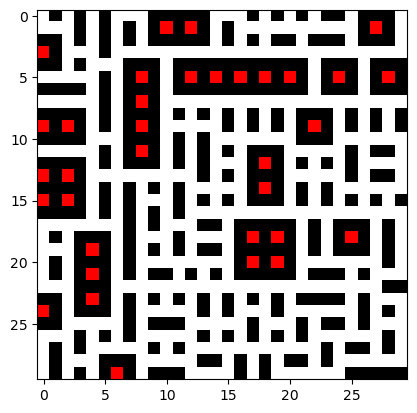

In [8]:
ABSOLUTE_PATH_FOR_VIDEO = r"C:\Users\sagea\final project"

wave = wave_function_collapse("RedMaze", 2, 30, ABSOLUTE_PATH_FOR_VIDEO, rotate=True, reflect=True, render=False)

im = coefficient_to_image(wave[0], np.array(wave[1]))

plt.imshow(im)
plt.show()